# Starbucks Capstone Challenge

# Part 1 - DEFINE

### ---- 1 Define the problem ----

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
#import your libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.max_columns = 999

#your info here
__author__ = "Sha Brown"
__email__ = "sha821@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
# load the data into a Pandas dataframe
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
# display the first 10 rows of the dataframe
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# print dataframe shape
portfolio.shape

(10, 6)

In [5]:
# display the first 5 rows of the dataframe
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
# print dataframe shape
profile.shape

(17000, 5)

In [7]:
# display the first 5 rows of the dataframe
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [8]:
# print dataframe shape
transcript.shape

(306534, 4)

In [9]:
# change dtype into str and remove "{}" symbol
transcript['value'] = (transcript['value']
                       .astype('str')
                       .str.replace('{','')
                       .str.replace('}','')
                      )

In [10]:
# split the value separated by ":"
transcript['value'] = transcript['value'].str.split(':')

In [11]:
# display the first 5 rows
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,"['offer id', '9b98b8c7a33c4b65b9aebfe6a799e6d9']",0
1,a03223e636434f42ac4c3df47e8bac43,offer received,"['offer id', '0b1e1539f2cc45b7b9fa7c272da2e1d7']",0
2,e2127556f4f64592b11af22de27a7932,offer received,"['offer id', '2906b810c7d4411798c6938adc9daaa5']",0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,"['offer id', 'fafdcd668e3743c1bb461111dcafc2a4']",0
4,68617ca6246f4fbc85e91a2a49552598,offer received,"['offer id', '4d5c57ea9a6940dd891ad53e9dbe8da0']",0


In [12]:
transcript.loc[0, 'value'][0] # test: extract the value from the first row

"'offer id'"

In [13]:
transcript.loc[0, 'value'][1] # test: extract the value from the first row

" '9b98b8c7a33c4b65b9aebfe6a799e6d9'"

In [14]:
# extract the value from the column
extract_offer = lambda x: x[0]
extract_value = lambda x: x[1]

# create new columns with extracted values
transcript['offer_or_amount'] = transcript['value'].apply(extract_offer)
transcript['id'] = transcript['value'].apply(extract_value)

In [15]:
# drop the original column
transcript = transcript.drop('value', axis=1)

In [16]:
transcript.head() # display the first 5 rows

,person,event,time,offer_or_amount,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,'offer id','9b98b8c7a33c4b65b9aebfe6a799e6d9'
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,'offer id','0b1e1539f2cc45b7b9fa7c272da2e1d7'
2,e2127556f4f64592b11af22de27a7932,offer received,0,'offer id','2906b810c7d4411798c6938adc9daaa5'
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,'offer id','fafdcd668e3743c1bb461111dcafc2a4'
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,'offer id','4d5c57ea9a6940dd891ad53e9dbe8da0'


In [17]:
# remove "_" and "'" from the column
transcript['offer_or_amount'] = (transcript['offer_or_amount']
                       .str.replace('_', '')
                       .str.replace("'", "")
                       )

In [18]:
# remove "'" from the column
transcript['id'] = transcript['id'].str.replace("'", "")
                             

In [19]:
# display the first 5 rows
transcript.head() 

,person,event,time,offer_or_amount,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [20]:
# change column name from 'person' to 'customer_id'
transcript.rename(columns={'person': 'customer_id', 'offer':'offer_id'}, inplace=True)

#### Merge Data

In [21]:
# change column name from 'id' to 'customer_id'
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [22]:
# first we will merge transcript with profile 
merged_df = transcript.merge(profile, on='customer_id', how='left')

In [23]:
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN


In [24]:
# check the first few rows of the dataframe
merged_df['id'].value_counts().head(20)

 2298d6c36e964ae4a3e7e9706d1fb8c2            14983
 fafdcd668e3743c1bb461111dcafc2a4            14924
 4d5c57ea9a6940dd891ad53e9dbe8da0            14891
 f19421c1d4aa40978ebb69ca19b0e20d            14835
 ae264e3637204a6fb9bb56bc8210ddfd            14374
 5a8bc65990b245e5a138643cd4eb9837            14305
 9b98b8c7a33c4b65b9aebfe6a799e6d9            11848
 3f207df678b143eea3cee63160fa8bed            11761
 2906b810c7d4411798c6938adc9daaa5            11750
 0b1e1539f2cc45b7b9fa7c272da2e1d7            10331
 fafdcd668e3743c1bb461111dcafc2a4, reward     5317
 2298d6c36e964ae4a3e7e9706d1fb8c2, reward     5156
 9b98b8c7a33c4b65b9aebfe6a799e6d9, reward     4354
 f19421c1d4aa40978ebb69ca19b0e20d, reward     4296
 2906b810c7d4411798c6938adc9daaa5, reward     4017
 ae264e3637204a6fb9bb56bc8210ddfd, reward     3688
 0b1e1539f2cc45b7b9fa7c272da2e1d7, reward     3420
 4d5c57ea9a6940dd891ad53e9dbe8da0, reward     3331
 0.05                                          431
 0.66                          

In [25]:
# remove"," and "reward" from offer_value column
merged_df['id'] = merged_df['id'].str.replace(",", "").str.replace('reward', '').str.replace(" ",'')

In [26]:
merged_df['id'].value_counts().head(10) # check the values counts for the 'id' column

fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: id, dtype: int64

In [27]:
# print out the shape of the dataframe
merged_df.shape

(306534, 9)

In [28]:
merged_df['offer_or_amount'].value_counts() # check the value counts for 'offer_or_amount' column

amount      138953
offer id    134002
offerid      33579
Name: offer_or_amount, dtype: int64

In [29]:
merged_df['event'].value_counts() # check the value counts for 'event' column

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [30]:
merged_df = merged_df.merge(portfolio, on='id', how='left') # merge portfolio dataframe

In [31]:
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [32]:
merged_df.isnull().sum() # check the null value counts

customer_id              0
event                    0
time                     0
offer_or_amount          0
id                       0
gender               33772
age                      0
became_member_on         0
income               33772
reward              138953
channels            138953
difficulty          138953
duration            138953
offer_type          138953
dtype: int64

### ---- 3 Clean the data ----

In [33]:
# extract all available channels
channels_set = set()
for channel in portfolio.channels:
    channels_set.update(set(channel))
channels_set

{'email', 'mobile', 'social', 'web'}

In [34]:
# create new columns corresponding to channels
for i in channels_set:
    merged_df[i] = merged_df['channels'].astype('str').apply(lambda x: i in x).map({True:1, False: 0})
merged_df.head()

,customer_id,event,time,offer_or_amount,id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,web,email,social,mobile
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount,1,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,1,1,1,1


In [35]:
# Create a one hot encoding function
def one_hot_encoding(dataframe, column_list):
    for column in column_list:
        column_dummies = pd.get_dummies(dataframe[column])
        dataframe = dataframe.drop(column, axis = 1)
        dataframe = dataframe.join(column_dummies)
    return dataframe

In [36]:
# Create dummy variables for columns in the column list
column_list = ['event', 'gender', 'offer_type']
merged_df = one_hot_encoding(merged_df, column_list)

In [37]:
merged_df.sort_values('customer_id').head(20) # check the first 20 rows sorted by 'customer_id' column

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer completed,offer received,offer viewed,transaction,F,M,O,bogo,discount,informational
302205,0009655768c64bdeb2e877511632db8f,696,amount,18.41,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
168412,0009655768c64bdeb2e877511632db8f,414,amount,8.57,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
300930,0009655768c64bdeb2e877511632db8f,690,amount,28.16,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
55972,0009655768c64bdeb2e877511632db8f,168,offer id,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,"[email, mobile, social]",0.0,3.0,0,1,1,1,0,1,0,0,0,1,0,0,0,1
153401,0009655768c64bdeb2e877511632db8f,408,offer id,f19421c1d4aa40978ebb69ca19b0e20d,33,20170421,72000.0,5.0,"[web, email, mobile, social]",5.0,5.0,1,1,1,1,0,1,0,0,0,1,0,1,0,0
233413,0009655768c64bdeb2e877511632db8f,540,offer id,fafdcd668e3743c1bb461111dcafc2a4,33,20170421,72000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,0,0,1,0,0,1,0,0,1,0
228422,0009655768c64bdeb2e877511632db8f,528,amount,14.11,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0
228423,0009655768c64bdeb2e877511632db8f,528,offerid,fafdcd668e3743c1bb461111dcafc2a4,33,20170421,72000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,0,0,1,0,0,1,0
77705,0009655768c64bdeb2e877511632db8f,192,offer id,5a8bc65990b245e5a138643cd4eb9837,33,20170421,72000.0,0.0,"[email, mobile, social]",0.0,3.0,0,1,1,1,0,0,1,0,0,1,0,0,0,1
293497,0009655768c64bdeb2e877511632db8f,660,amount,12.36,33,20170421,72000.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [38]:
merged_df['customer_id'].nunique() # display the unique counts of 'customer_id'

17000

In [39]:
merged_df['customer_id'].unique() # look at the unique values

array(['78afa995795e4d85b5d9ceeca43f5fef',
       'a03223e636434f42ac4c3df47e8bac43',
       'e2127556f4f64592b11af22de27a7932', ...,
       '912b9f623b9e4b4eb99b6dc919f09a93',
       '3045af4e98794a04a5542d3eac939b1f',
       'da7a7c0dcfcb41a8acc7864a53cf60fb'], dtype=object)

In [40]:
portfolio['id'].unique() # look at the unique values of the 'id' column

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [41]:
# replace 'offerid' with 'offer id'
merged_df['offer_or_amount'] = merged_df['offer_or_amount'].str.replace('offerid', 'offer id')

In [42]:
merged_df['offer_or_amount'].value_counts() # display value counts of the 'offer_or_amount column'

offer id    167581
amount      138953
Name: offer_or_amount, dtype: int64

In [43]:
merged_df.shape # display the shape of merged_df

(306534, 25)

In [44]:
def sort_by_event(df, event_col, time_name):
    """Create a new dataframe with the only the chosen event type
    
    Args:
    
    df(dataframe): a pandas dataframe object
    event_col(str): the name of the event column e.g 'offer received'
    time_name(str): the name of the time associated with event 
    
    Return:
    
    new_df(datafame): a pandas dataframe object   
    """
    new_df = df[df[event_col]==1].copy()
    new_df[time_name] = new_df['time']
    new_df.sort_values('time', ascending=True, inplace=True)
    new_df.drop_duplicates(subset=['customer_id', 'id'], keep='first', inplace=True)
    return new_df

In [45]:
# Create a new dataframe with the 'offer received' event
received_df = sort_by_event(merged_df, 'offer received', 'received time') 

In [46]:
# Drop the extra columns we don't need
received_df = received_df.drop(columns=['offer completed', 'offer viewed'], axis=1)

In [47]:
# Create a new dataframe with the 'offer viewed' event
viewed_df = sort_by_event(merged_df, 'offer viewed', 'viewed time')

In [48]:
# Drop the columns that we don't need
viewed_df = viewed_df[['customer_id','id','offer viewed', 'viewed time']]

In [49]:
viewed_df.head() # Display the first 5 rows

,customer_id,id,offer viewed,viewed time
12650,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0
14605,bf5783772fee4f2ab126f07bf3be80f1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0
14604,14cbeafc2297453e9bf4924c2eabe35e,fafdcd668e3743c1bb461111dcafc2a4,1,0
14603,324cde983eef4759ace1e2e30816b751,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0
14602,79e3b16de4964b6c82e45e0014a42502,5a8bc65990b245e5a138643cd4eb9837,1,0


In [50]:
# Create a new dataframe with the 'offer complted' event
completed_df = sort_by_event(merged_df, 'offer completed', 'completed time')

In [51]:
# Keep the columns we need
completed_df = completed_df[['customer_id', 'id','offer completed', 'completed time']]

In [52]:
print(received_df.shape) # Display shape

(63288, 24)


In [53]:
print(viewed_df.shape) 

(49135, 4)


In [54]:
print(completed_df.shape)

(28996, 4)


In [55]:
# merge two dataframes received_df, viewed_df
merged_events = pd.merge(received_df,viewed_df, on=['customer_id', 'id'], how='left') 

In [56]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,6.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"[email, mobile, social]",0.0,3.0,0,1,1,1,1,0,1,0,0,0,0,1,0,1.0,90.0
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"[web, email]",20.0,10.0,1,1,0,0,1,0,0,0,0,0,1,0,0,1.0,84.0
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0


In [57]:
# merge completed_df dataframe
merged_events = pd.merge(merged_events, completed_df, on=['customer_id', 'id'], how='left')

In [58]:
merged_events.shape

(63288, 28)

In [59]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"[email, mobile, social]",0.0,3.0,0,1,1,1,1,0,1,0,0,0,0,1,0,1.0,90.0,NaN,NaN
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"[web, email, mobile, social]",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0,1.0,156.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"[web, email]",20.0,10.0,1,1,0,0,1,0,0,0,0,0,1,0,0,1.0,84.0,NaN,NaN
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0,1.0,78.0


In [60]:
merged_events[(merged_events['viewed time']) > (merged_events['completed time'])]

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
18,88ed0c64fb0d474ebca47efa94d623eb,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,70,20170404,74000.0,10.0,"[email, mobile, social]",10.0,7.0,0,1,1,1,1,0,1,0,0,1,0,0,0,1.0,78.0,1.0,72.0
51,24e1795cb9894e078644210adf514d18,0,offer id,2906b810c7d4411798c6938adc9daaa5,55,20180315,79000.0,2.0,"[web, email, mobile]",10.0,7.0,1,1,0,1,1,0,0,0,1,0,1,0,0,1.0,66.0,1.0,42.0
55,8eecf3a6faf84c2d8ece8898c91c86b3,0,offer id,ae264e3637204a6fb9bb56bc8210ddfd,69,20170915,102000.0,10.0,"[email, mobile, social]",10.0,7.0,0,1,1,1,1,0,0,1,0,1,0,0,0,1.0,696.0,1.0,126.0
72,45e5d63c00cc41bd8d8d6f11e43b4d67,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,78,20151004,79000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,1,0,0,1,0,0,0,1.0,18.0,1.0,6.0
86,e95473793bf441cb96dca619d37777ed,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,48,20180308,84000.0,5.0,"[web, email, mobile]",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,114.0,1.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63246,0fc637442b954432b13c360af61d4256,576,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,43,20150803,57000.0,3.0,"[web, email, mobile, social]",7.0,7.0,1,1,1,1,1,0,1,0,0,0,1,0,576,1.0,600.0,1.0,576.0
63272,313fac53644243e49cb3153e34176463,576,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,61,20170905,97000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,588.0,1.0,576.0
63279,3bc615dbfcdd40039113a5f9824c892f,576,offer id,f19421c1d4aa40978ebb69ca19b0e20d,36,20170730,46000.0,5.0,"[web, email, mobile, social]",5.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,678.0,1.0,600.0
63284,94206fc6b89b4ae8b39d2cc9d870ef4d,576,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,61,20161019,114000.0,10.0,"[web, email, mobile, social]",10.0,5.0,1,1,1,1,1,0,0,1,0,1,0,0,576,1.0,612.0,1.0,582.0


In [61]:
merged_events.to_csv('merged_events.csv', index=False) # Save as csv

In [62]:
merged_events = pd.read_csv('merged_events.csv')

In [63]:
merged_events.head()

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,20170509,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78,20170708,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,0,1,1,1,1,0,1,0,0,0,0,1,0,1.0,90.0,NaN,NaN
2,64257c0ea273425d8821644f040b79d9,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,24,20170825,64000.0,2.0,"['web', 'email', 'mobile', 'social']",10.0,10.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,0.0,1.0,156.0
3,353697e3573c49cebed67da5d6fb49f9,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,20180210,NaN,5.0,"['web', 'email']",20.0,10.0,1,1,0,0,1,0,0,0,0,0,1,0,0,1.0,84.0,NaN,NaN
4,aff95fbae22348daa57ca6ef60a85f8c,0,offer id,2298d6c36e964ae4a3e7e9706d1fb8c2,59,20180226,41000.0,3.0,"['web', 'email', 'mobile', 'social']",7.0,7.0,1,1,1,1,1,0,0,1,0,0,1,0,0,1.0,6.0,1.0,78.0


In [64]:
merged_events.isnull().sum() # check the null values in the dataframe

customer_id             0
time                    0
offer_or_amount         0
id                      0
age                     0
became_member_on        0
income               8066
reward                  0
channels                0
difficulty              0
duration                0
web                     0
email                   0
social                  0
mobile                  0
offer received          0
transaction             0
F                       0
M                       0
O                       0
bogo                    0
discount                0
informational           0
received time           0
offer viewed        14153
viewed time         14153
offer completed     34292
completed time      34292
dtype: int64

In [65]:
merged_events.duplicated().sum() # check for duplicates

0

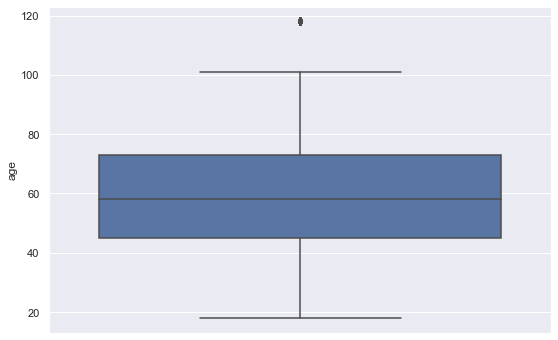

In [66]:
# identify outliers
plt.figure(figsize=(9,6))
sns.set(style='darkgrid')
sns.boxplot(y=merged_events['age'])

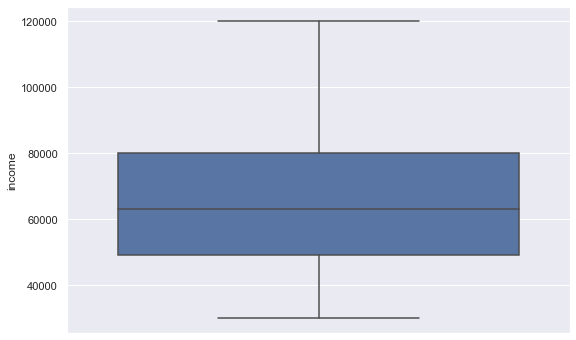

In [67]:
# identify outliers
plt.figure(figsize=(9,6))
sns.boxplot(y=merged_events['income'])

In [68]:
def find_boundaries(df, variable):

    """Return the boundaries for defining outliers
    
    Arg:
    df(dataframe): a pandas dataframe object
    variable(str): the name of the variable
    
    Return:
    upper_boundary(float): values that are bigger than upper boundary
    lower_boundary(float): values that are smaller than the lower boundary
    """

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

In [69]:
upper_boundary, lower_boundary = find_boundaries(merged_events, 'age') # identity boundaries in the 'age' variable
upper_boundary, lower_boundary

(115.0, 3.0)

In [70]:
merged_events['age'].value_counts(bins = 10).sort_index(ascending=True)

(17.898999999999997, 28.0]     5442
(28.0, 38.0]                   5520
(38.0, 48.0]                   8023
(48.0, 58.0]                  13063
(58.0, 68.0]                  11573
(68.0, 78.0]                   7072
(78.0, 88.0]                   3330
(88.0, 98.0]                   1122
(98.0, 108.0]                    77
(108.0, 118.0]                 8066
Name: age, dtype: int64

In [71]:
len(merged_events[merged_events['age']>115]) # display the counts of outliers

8066

In [72]:
min(merged_events['age']) # check the minimum age

18

In [73]:
min(merged_events['income']) # check the minimum income value

30000.0

In [74]:
merged_events["age"] = np.where(merged_events["age"] >115, np.nan, merged_events['age']) # replace outliers with np.nan 

In [75]:
merged_events['age'].value_counts(bins=12)

(52.583, 59.5]      9503
(59.5, 66.417]      8131
(45.667, 52.583]    7602
(66.417, 73.333]    6285
(38.75, 45.667]     5308
(31.833, 38.75]     4145
(73.333, 80.25]     3772
(24.917, 31.833]    3537
(17.916, 24.917]    3280
(80.25, 87.167]     2225
(87.167, 94.083]    1176
(94.083, 101.0]      258
Name: age, dtype: int64

In [76]:
merged_events['income'].isnull().sum() # null value counts in the 'income' column

8066

In [77]:
merged_events['age'] = merged_events['age'].replace(np.nan, -0.5) #temporily fill the null values with -0.5

In [78]:
merged_events['income'] = merged_events['income'].replace(np.nan, -0.5) #temporily fill the null values with -0.5

In [79]:
merged_events.fillna(0,inplace=True) # replace null values with 0 for the rest of the columns

In [80]:
merged_events.isnull().sum() # display the null value counts

customer_id         0
time                0
offer_or_amount     0
id                  0
age                 0
became_member_on    0
income              0
reward              0
channels            0
difficulty          0
duration            0
web                 0
email               0
social              0
mobile              0
offer received      0
transaction         0
F                   0
M                   0
O                   0
bogo                0
discount            0
informational       0
received time       0
offer viewed        0
viewed time         0
offer completed     0
completed time      0
dtype: int64

In [81]:
# change the column to pandas datetime 
merged_events['became_member_on'] = pd.to_datetime(merged_events['became_member_on'], format='%Y%m%d')

In [82]:
merged_events.head(2)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78.0,2017-07-08,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,0,1,1,1,1,0,1,0,0,0,0,1,0,1.0,90.0,0.0,0.0


In [83]:
ts = pd.to_datetime('20200101', format='%Y%m%d') # create a timestamp

In [84]:
# find out memship length with the timestamp we created
merged_events['membership length'] = ts - merged_events['became_member_on'] 

In [85]:
# extract only the days from the column
merged_events['membership length'] = merged_events['membership length'].astype('str').str[0:4].replace(" ",'')

In [86]:
merged_events.head(2)

,customer_id,time,offer_or_amount,id,age,became_member_on,income,reward,channels,difficulty,duration,web,email,social,mobile,offer received,transaction,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
0,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,100000.0,5.0,"['web', 'email', 'mobile']",5.0,7.0,1,1,0,1,1,0,1,0,0,1,0,0,0,1.0,6.0,1.0,132.0,967
1,05c001b0be8a436dba8f7fdb7ac9273b,0,offer id,5a8bc65990b245e5a138643cd4eb9837,78.0,2017-07-08,42000.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,0,1,1,1,1,0,1,0,0,0,0,1,0,1.0,90.0,0.0,0.0,907


In [87]:
merged_events.dtypes

customer_id                  object
time                          int64
offer_or_amount              object
id                           object
age                         float64
became_member_on     datetime64[ns]
income                      float64
reward                      float64
channels                     object
difficulty                  float64
duration                    float64
web                           int64
email                         int64
social                        int64
mobile                        int64
offer received                int64
transaction                   int64
F                             int64
M                             int64
O                             int64
bogo                          int64
discount                      int64
informational                 int64
received time                 int64
offer viewed                float64
viewed time                 float64
offer completed             float64
completed time              

In [88]:
# convert dtypes into integer
merged_events['membership length'] = merged_events['membership length'].astype('int')
merged_events['offer viewed'] = merged_events['offer viewed'].astype('int')
merged_events['offer completed'] = merged_events['offer completed'].astype('int')

In [89]:
merged_events.columns

Index(['customer_id', 'time', 'offer_or_amount', 'id', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'web', 'email', 'social', 'mobile', 'offer received',
       'transaction', 'F', 'M', 'O', 'bogo', 'discount', 'informational',
       'received time', 'offer viewed', 'viewed time', 'offer completed',
       'completed time', 'membership length'],
      dtype='object')

In [90]:
# drop columns that we no longer needs
merged_events = merged_events.drop(['customer_id', 'time', 
                                    'offer_or_amount', 'id', 
                                    'became_member_on','channels',
                                    'offer received', 'transaction'],
                                    axis = 1
                                   )

In [91]:
merged_events.head()

,age,income,reward,difficulty,duration,web,email,social,mobile,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
0,75.0,100000.0,5.0,5.0,7.0,1,1,0,1,1,0,0,1,0,0,0,1,6.0,1,132.0,967
1,78.0,42000.0,0.0,0.0,3.0,0,1,1,1,1,0,0,0,0,1,0,1,90.0,0,0.0,907
2,24.0,64000.0,2.0,10.0,10.0,1,1,1,1,0,1,0,0,1,0,0,1,0.0,1,156.0,859
3,-0.5,-0.5,5.0,20.0,10.0,1,1,0,0,0,0,0,0,1,0,0,1,84.0,0,0.0,690
4,59.0,41000.0,3.0,7.0,7.0,1,1,1,1,0,1,0,0,1,0,0,1,6.0,1,78.0,674


In [92]:
# find out who completed offer without viewing the offer
completed_not_viewed = merged_events[(merged_events['offer viewed']==0)&(merged_events['offer completed']==1)]
len(completed_not_viewed)

4536

In [93]:
# find out who completed offer before viewing the offer
completed_before_viewed = merged_events[((merged_events['offer viewed']==1)&(merged_events['offer completed']==1))
                                    &(merged_events['viewed time']>merged_events['completed time'])]
len(completed_before_viewed)

3708

In [94]:
complete_no_promo = pd.concat([completed_not_viewed, completed_before_viewed], axis=0)
len(complete_no_promo)

8244

In [95]:
merged_events = merged_events.drop(index=complete_no_promo.index)
merged_events.shape

(55044, 21)

In [96]:
merged_events.to_csv('cleaned_df.csv', index=False)

### ---- 4 Explore the data (EDA) ----

In [97]:
cleaned_df = pd.read_csv('cleaned_df.csv')

In [98]:
# display discriptive statistics
cleaned_df.describe() 

,age,income,reward,difficulty,duration,web,email,social,mobile,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length
count,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.0,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000,55044.000000
mean,46.201076,55158.328537,4.103699,7.304575,6.345596,0.785063,1.0,0.634420,0.916376,0.340273,0.503216,0.012481,0.391232,0.378933,0.229834,302.299106,0.825285,269.176368,0.377007,141.735993,1032.753252
std,25.032506,29996.839033,3.500657,5.442768,2.233539,0.410782,0.0,0.481597,0.276826,0.473805,0.499994,0.111020,0.488031,0.485126,0.420730,200.646483,0.379726,220.824185,0.484641,219.218085,415.327866
min,-0.500000,-0.500000,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,524.000000
25%,31.000000,39000.000000,2.000000,5.000000,5.000000,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,1.000000,12.000000,0.000000,0.000000,724.000000
50%,51.000000,57000.000000,3.000000,7.000000,7.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,336.000000,1.000000,288.000000,0.000000,0.000000,871.500000
75%,64.000000,75000.000000,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,504.000000,1.000000,456.000000,1.000000,276.000000,1306.000000
max,101.000000,120000.000000,10.000000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,576.000000,1.000000,714.000000,1.000000,714.000000,2347.000000


In [99]:
# create distribution plot
def plot_dist(col):
    plt.figure(figsize=(9,6))
    sns.set(style='darkgrid')
    sns.distplot(col, bins=10)
    plt.show()

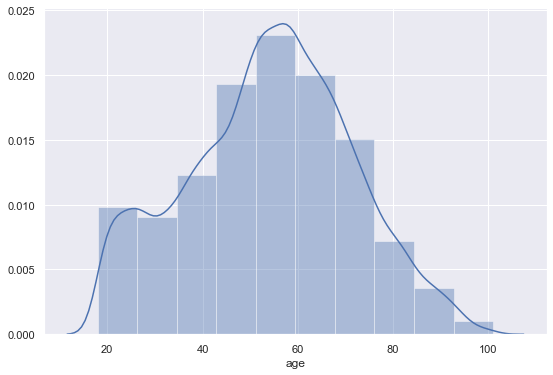

In [100]:
# distibution plot for the 'age' column
plot_dist(cleaned_df[cleaned_df['age']>0]['age'])

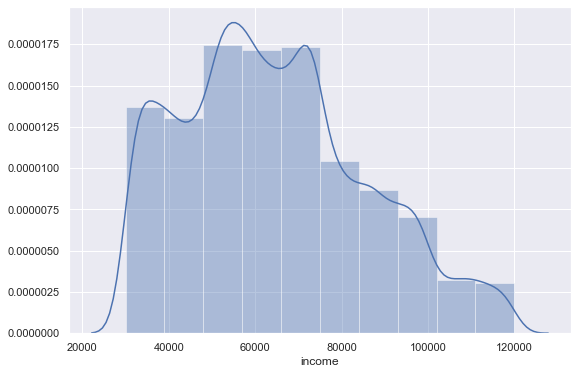

In [101]:
# distibution plot for the 'income' column
plot_dist(cleaned_df[cleaned_df['income']>0]['income'])

In [102]:
# create bar plot
def plot_bar(col):
    plt.figure(figsize=(9,6))
    sns.set(style='darkgrid')
    col.value_counts().plot.bar()
    plt.xticks(rotation=0)
    plt.show()

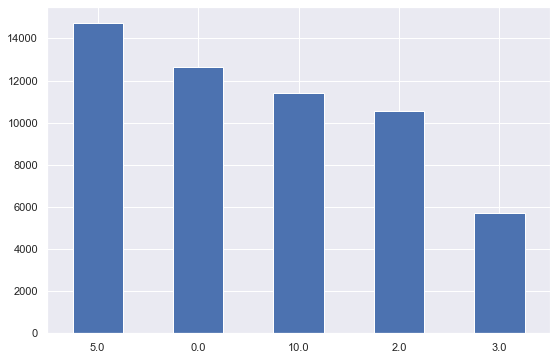

In [103]:
# bar plot for the 'reward' column
plot_bar(cleaned_df['reward'])

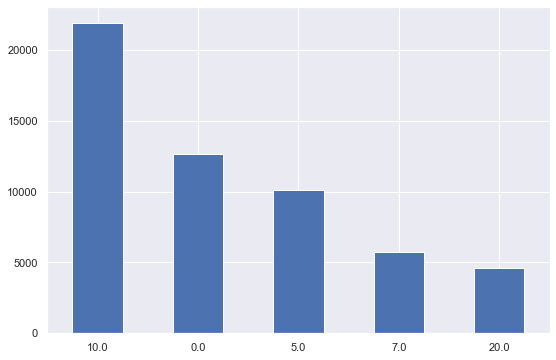

In [104]:
# bar plot for the 'difficulty' column
plot_bar(cleaned_df['difficulty'])

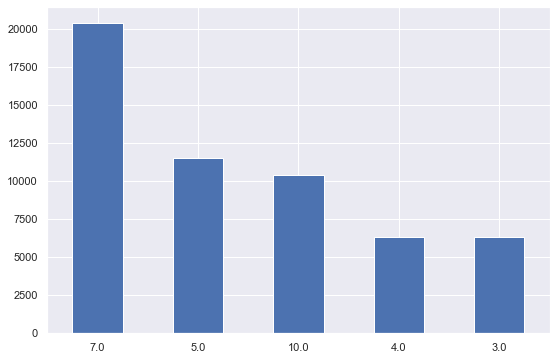

In [105]:
# bar plot for 'duration' column
plot_bar(cleaned_df['duration'])

In [106]:
# create a dataframe with only completed offers
completed_offer_df = cleaned_df[cleaned_df['offer completed']==1].copy() 

In [107]:
# create a dataframe where the informational offer is True
informational = cleaned_df[cleaned_df['informational']==1]

In [108]:
# create a dataframe by category we choose
# show the total sum and the total sum of completed offers
def create_category_df(list, category_name):
    df = pd.DataFrame({'total': [cleaned_df[x].sum() for x in list],
                       'offer completed': [completed_offer_df[x].sum() for x in list],
                       'percentages': [completed_offer_df[x].sum()/cleaned_df[x].sum() for x in list]},
                       index=[i for i in list] 
                      )
    df = df.reset_index().rename(columns={'index': category_name})
    return df

In [109]:
# create a dataframe by the gender category
gender_list = ['F', 'M', 'O']
gender_df = create_category_df(gender_list, 'gender')

In [110]:
gender_df # check the dataframe

,gender,total,offer completed,percentages
0,F,18730,9181,0.490176
1,M,27699,10308,0.372143
2,O,687,347,0.505095


In [111]:
# create a dataframe by the channel dataframe
channel_list = ['social', 'web', 'mobile','email'] 
channel_df = create_category_df(channel_list, 'channel')

In [112]:
channel_df

,channel,total,offer completed,percentages
0,social,34921,15732,0.450503
1,web,43213,18438,0.426677
2,mobile,50441,19545,0.387482
3,email,55044,20752,0.377007


In [113]:
# create a dataframe by the offer category
offer_list = ['informational', 'bogo', 'discount']
offer_df = create_category_df(offer_list, 'offer')

In [114]:
offer_df

,offer,total,offer completed,percentages
0,informational,12651,0,0.000000
1,bogo,21535,9801,0.455120
2,discount,20858,10951,0.525026


In [115]:
def plot_comparison_bar(df, title):
    # Create figure
    plt.figure(figsize=(10, 5), dpi=300)
    width=0.3
    # Create bar plot
    pos = np.arange(len(df[df.columns[0]]))
    plt.bar(pos - width / 2, df[df.columns[1]], width, label=df.columns[1])
    plt.bar(pos + width / 2, df[df.columns[2]], width, label=df.columns[2])
    # Specify ticks
    plt.xticks(pos, rotation=0)
    # Get current Axes for setting tick labels and horizontal grid
    ax = plt.gca()
    # Set tick labels
    ax.set_xticklabels(df[df.columns[0]])
    plt.title(title)
    # Add legend
    plt.legend()
    # Show plot
    plt.show()

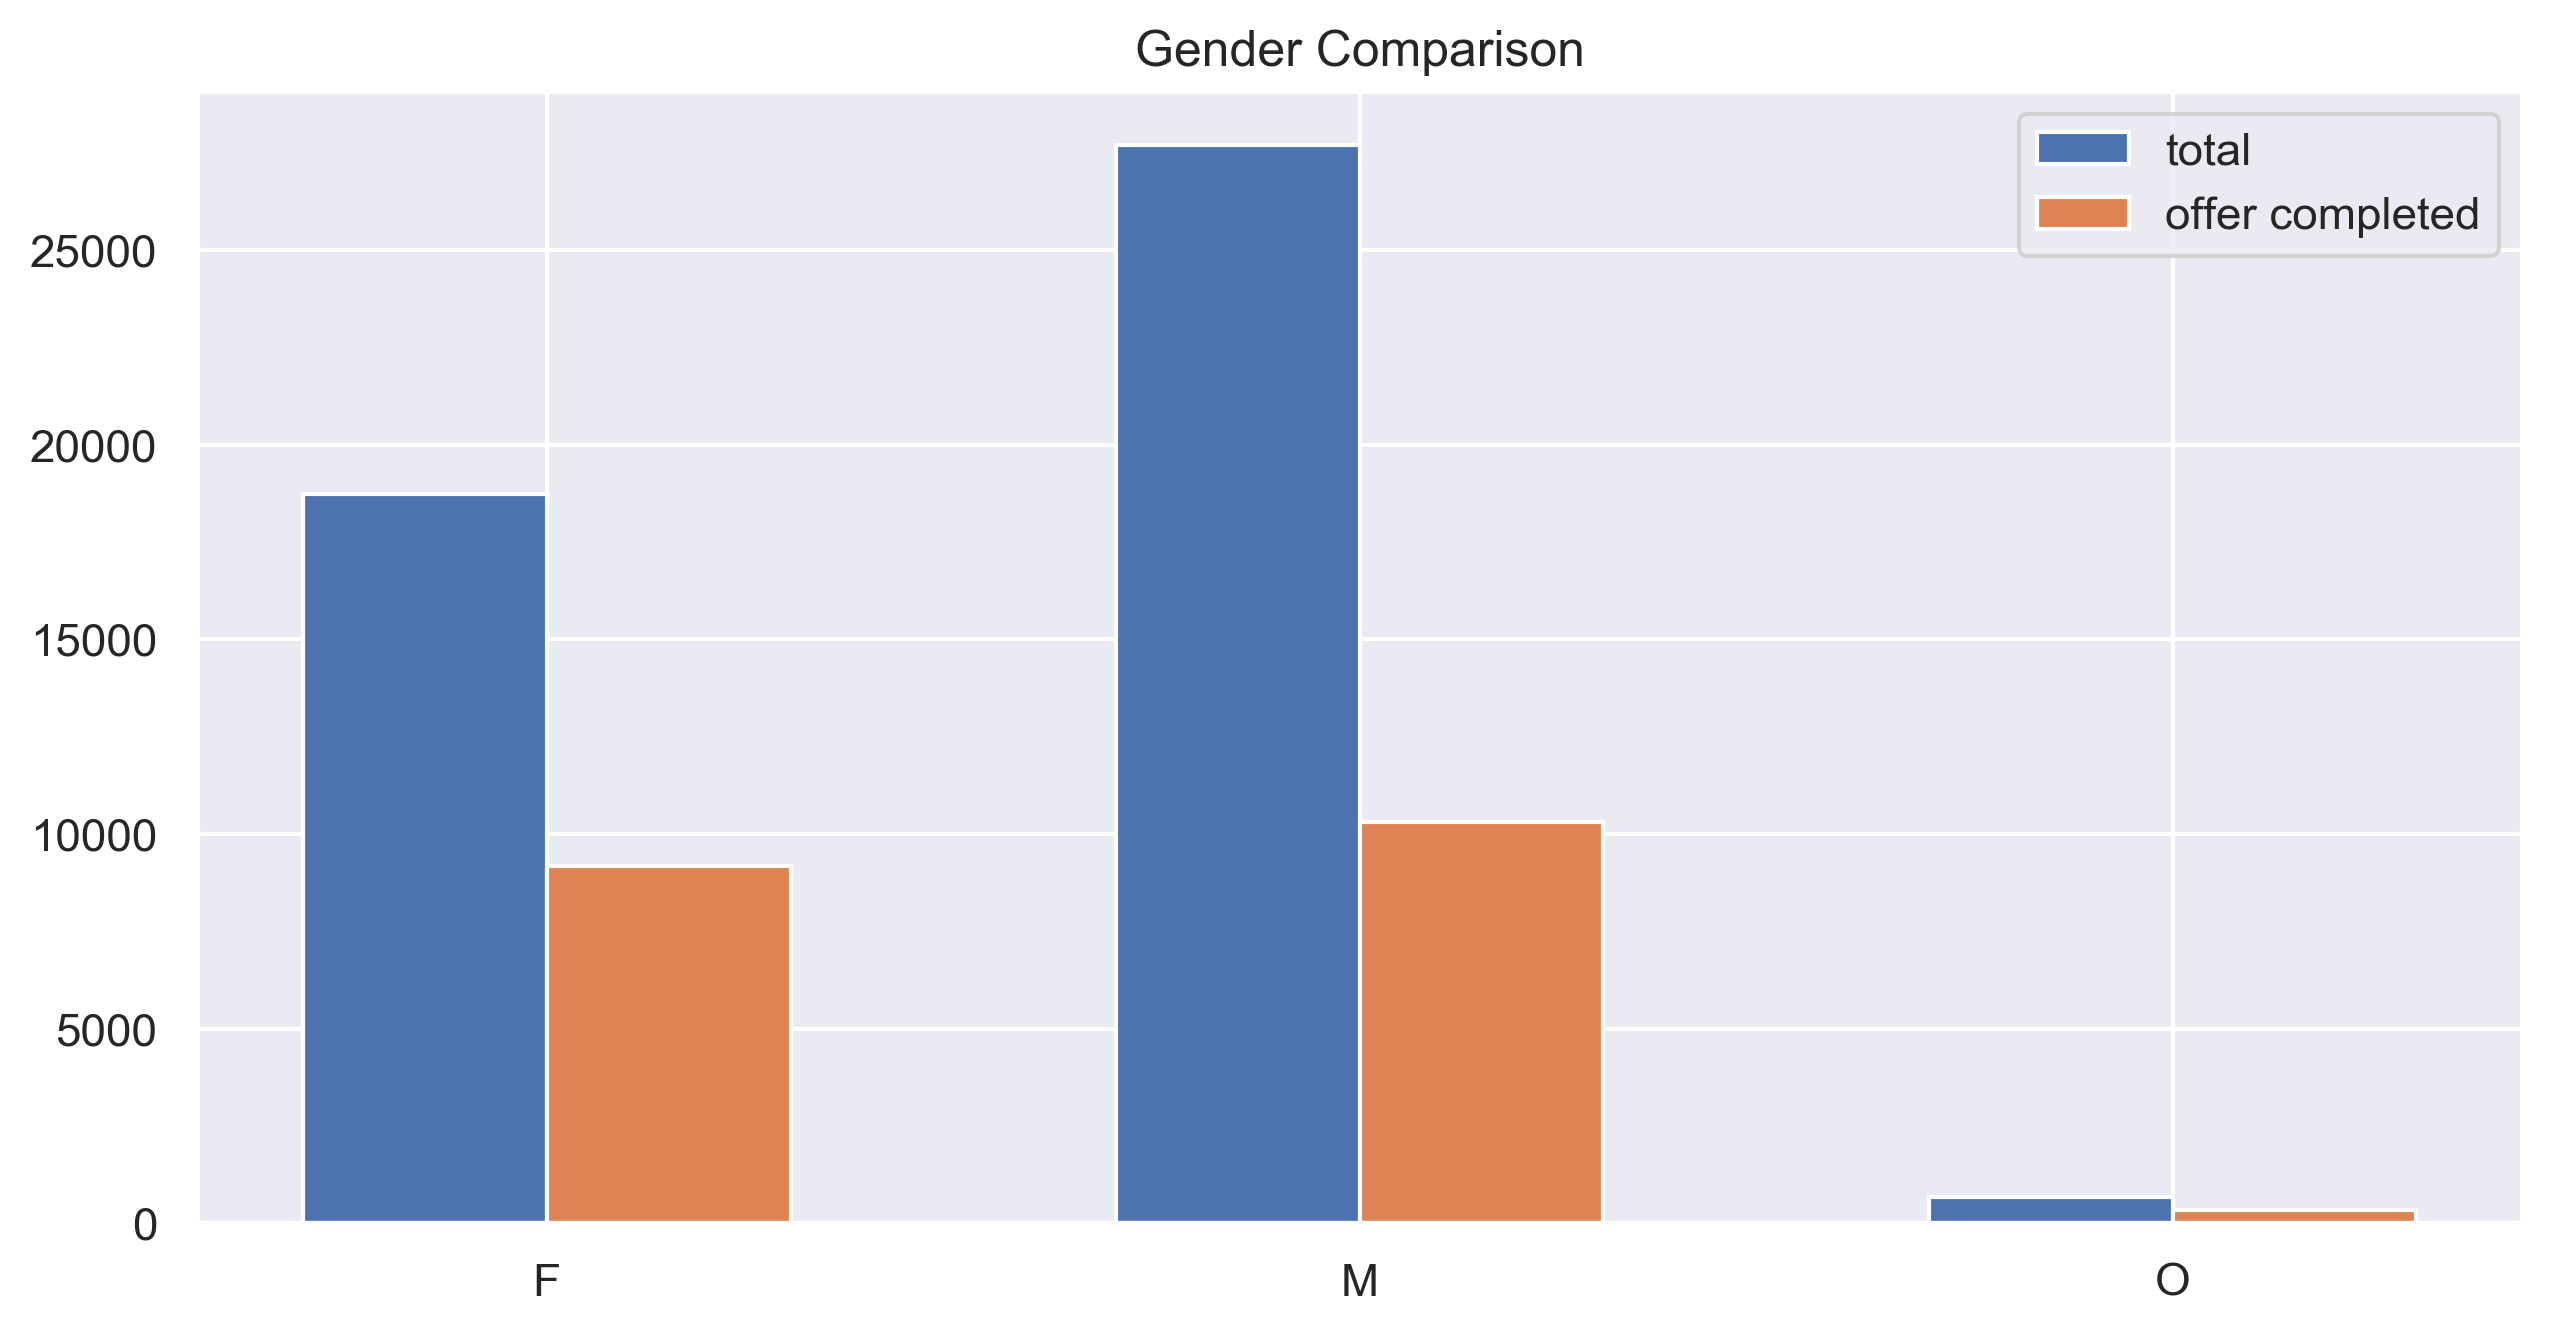

In [116]:
plot_comparison_bar(gender_df, 'Gender Comparison') # create gender comparison bar plot

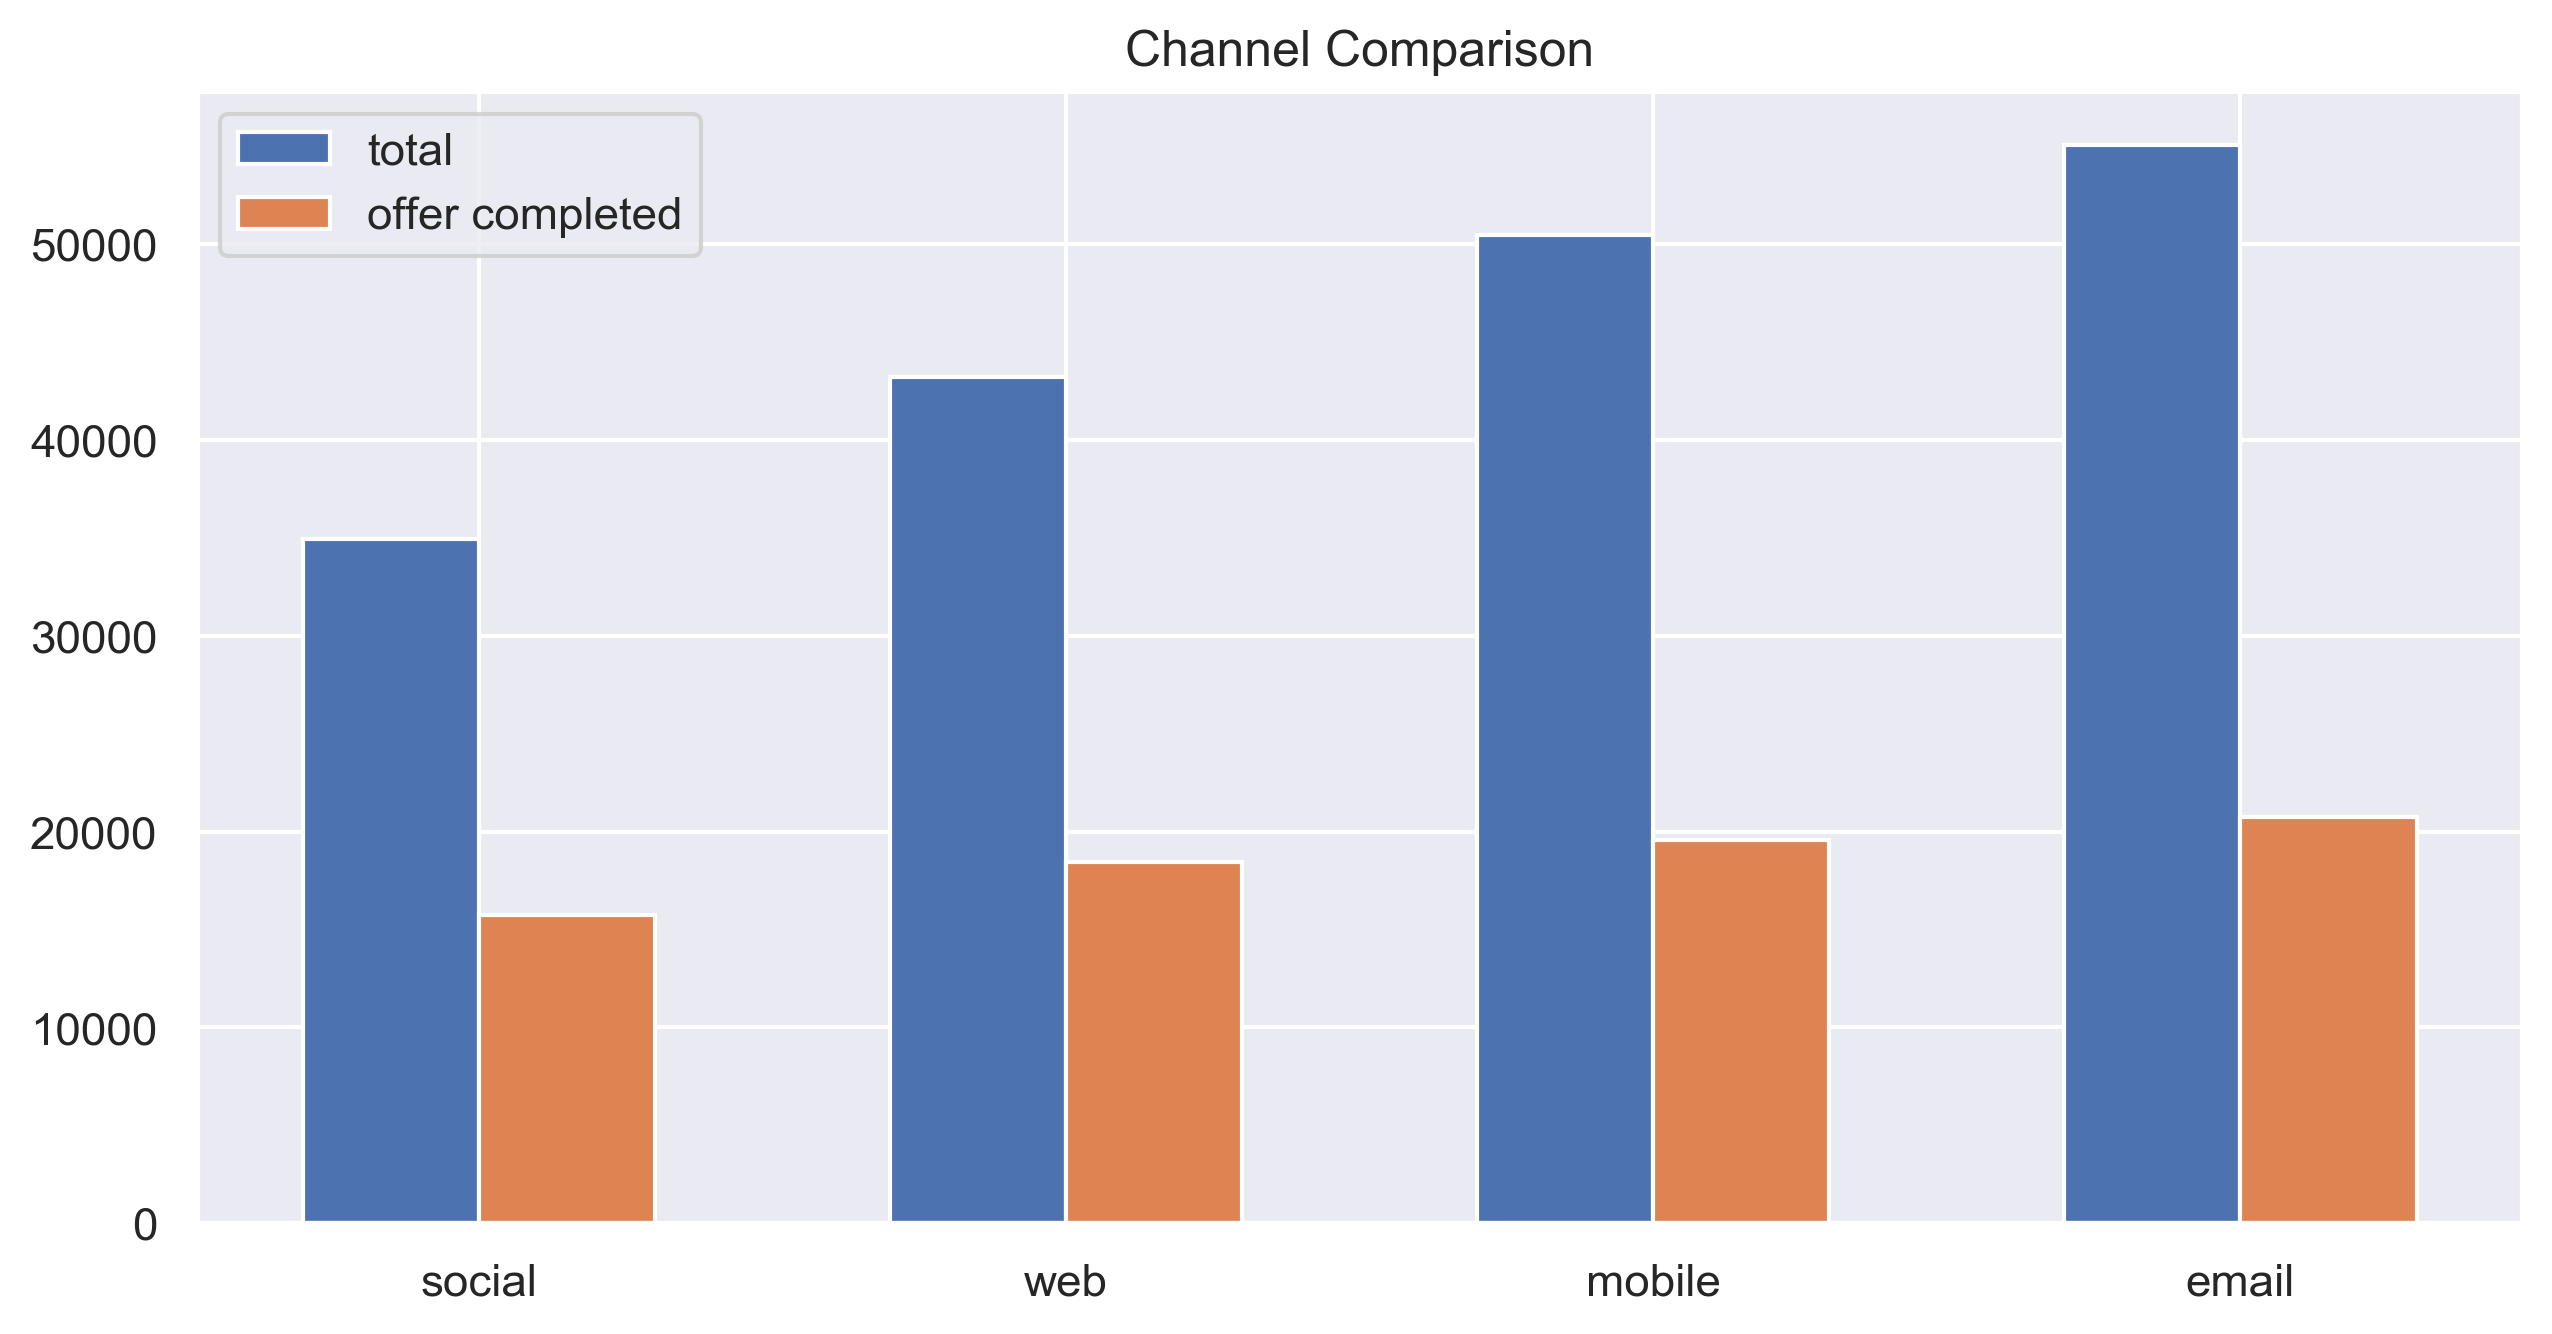

In [117]:
plot_comparison_bar(channel_df, 'Channel Comparison') # create channel comparison bar plot

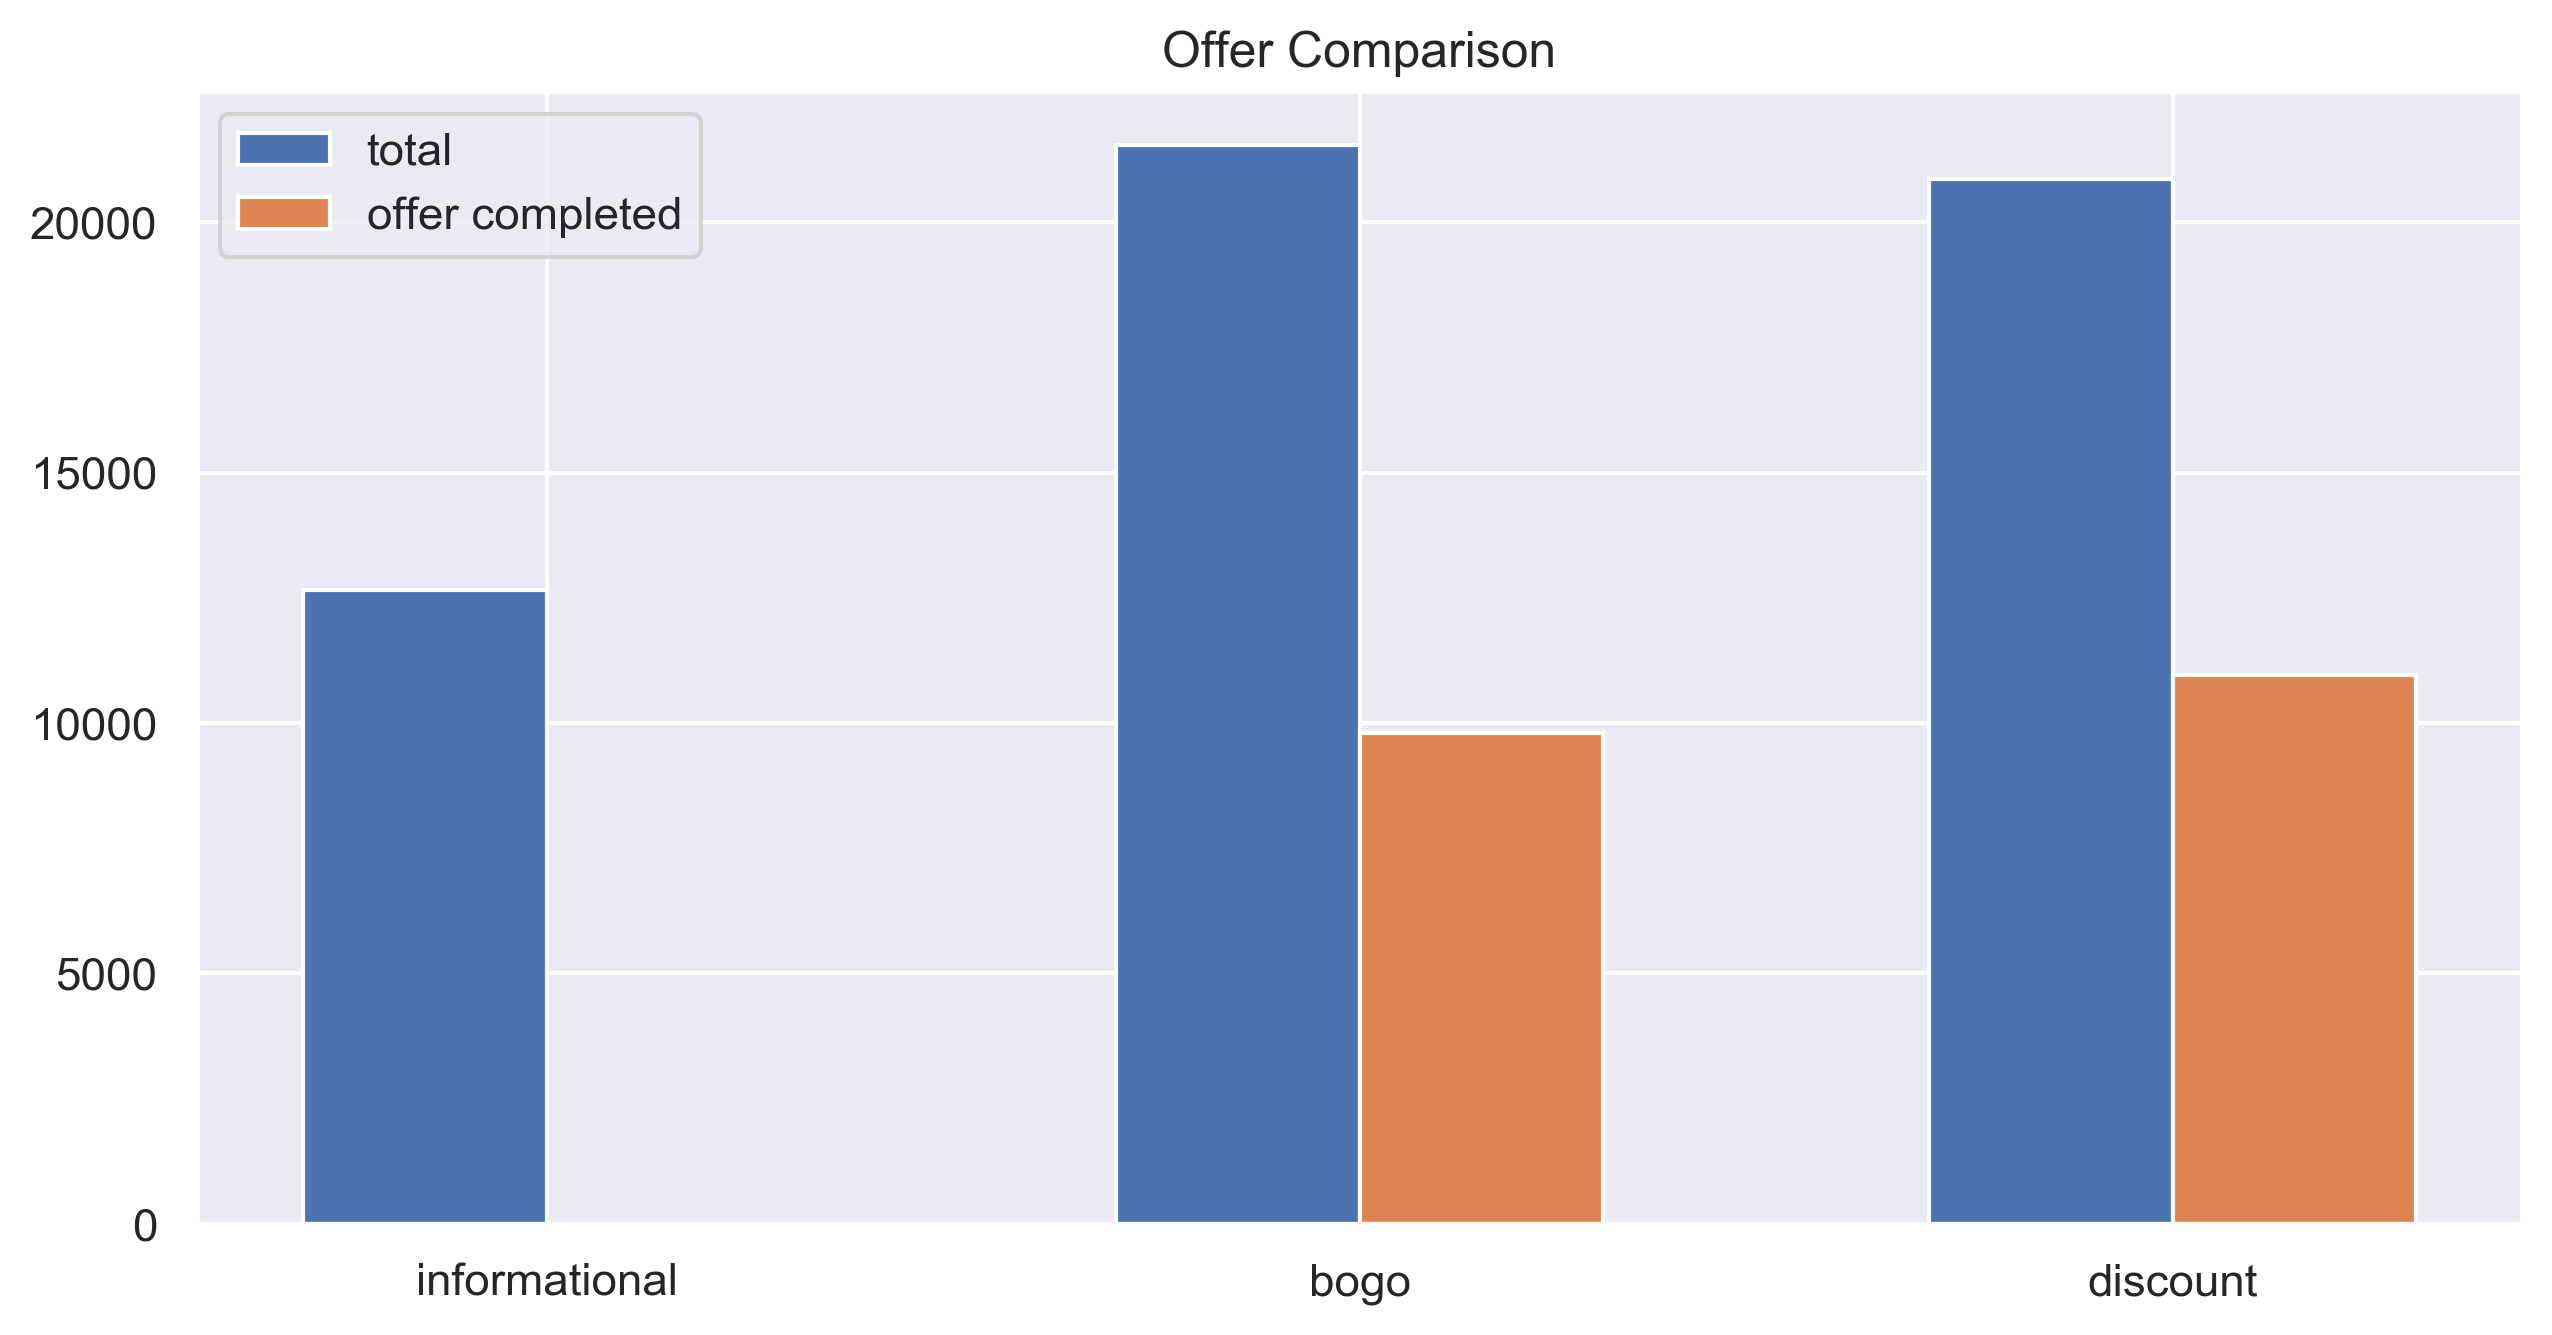

In [118]:
plot_comparison_bar(offer_df, 'Offer Comparison') # create offer comparison bar plot

In [119]:
cleaned_df = cleaned_df.drop('email', axis=1)

In [120]:
matrix = cleaned_df.corr()['offer completed']
matrix = matrix.sort_values(ascending=True)

In [121]:
matrix

informational       -0.424961
received time       -0.025733
M                   -0.010101
O                    0.029713
mobile               0.071549
bogo                 0.129209
membership length    0.161838
F                    0.167703
viewed time          0.169320
reward               0.181381
web                  0.195872
social               0.199774
difficulty           0.215511
age                  0.217355
discount             0.238568
income               0.272171
duration             0.304960
offer viewed         0.357929
completed time       0.831140
offer completed      1.000000
Name: offer completed, dtype: float64

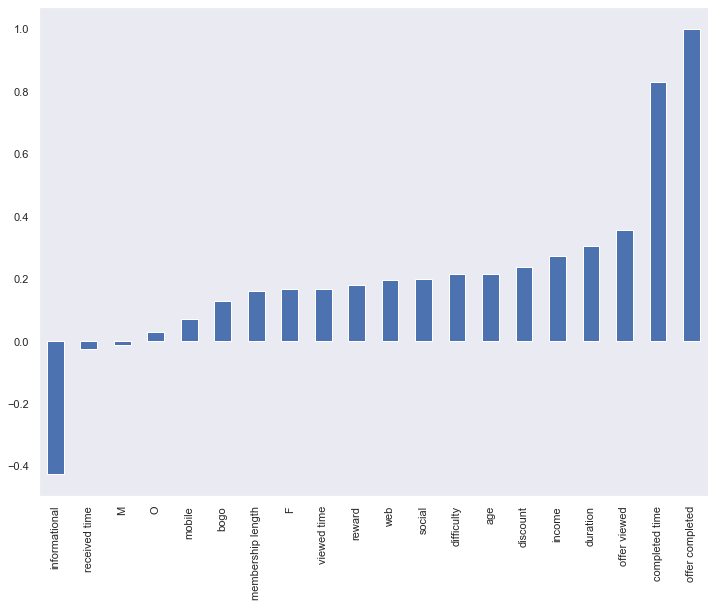

In [122]:
plt.figure(figsize=(12,9))
sns.set(style='dark')
matrix.plot.bar()

In [123]:
np.abs(matrix).sort_values()

M                    0.010101
received time        0.025733
O                    0.029713
mobile               0.071549
bogo                 0.129209
membership length    0.161838
F                    0.167703
viewed time          0.169320
reward               0.181381
web                  0.195872
social               0.199774
difficulty           0.215511
age                  0.217355
discount             0.238568
income               0.272171
duration             0.304960
offer viewed         0.357929
informational        0.424961
completed time       0.831140
offer completed      1.000000
Name: offer completed, dtype: float64

### ---- 5 Establish a baseline ----

In [124]:
features = cleaned_df.drop(columns=['completed time', 'offer viewed',
                                    'viewed time', 'offer completed'])
features.head(2)

,age,income,reward,difficulty,duration,web,social,mobile,F,M,O,bogo,discount,informational,received time,membership length
0,75.0,100000.0,5.0,5.0,7.0,1,0,1,1,0,0,1,0,0,0,967
1,78.0,42000.0,0.0,0.0,3.0,0,1,1,1,0,0,0,0,1,0,907


In [125]:
target = cleaned_df['offer completed']

In [126]:
# create training set and testing set
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.3,
                                                                            )

In [127]:
# initiate a logistic regression model
lr = LogisticRegression()
# fit the training set
lr.fit(features_train, target_train)
predictions = lr.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
f1 = f1_score(target_test, predictions)
print('The accuracy score for this logistic regression model is {:.2f}'.format(accuracy))
print('The f1 score for this logistic regression model is {:.2f}'.format(f1))

The accuracy score for this logistic regression model is 0.61
The f1 score for this logistic regression model is 0.40


### ---- 6 Hypothesize solution ----

The baseline model is not ideal. The accuracy score is just a little better than guessing.   
To improve performance, I propose the following:   
1. The age variable has a large standard deviation. We can standardize the data or alternative we can categories the ages into the following groups: unknown, young, middle-aged, older adults.   
2. The same goes for the income variable as well. We can categorize this variable into the following group: "unknown", "low income", "middle income", and "high income".   
3. We can use standard scaler inside Scikitlearn to standardize those variables: "reward",  "difficulty", "duration", and "membership length".   
4. We can use other machine learning models such as random forest classifiers since it is more Robust to Outliers and Non-linear Data.   

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [128]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    cut_points = [-1,17,35,60,100]
    label_names = ["unknown","young adult","adult","senior"]
    df["age_categories"] = pd.cut(df["age"],cut_points,labels=label_names)
    return df

def process_income(df):
    """Process the income column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    cut_points = [-1,0,40000,80000,120000]
    label_names = ["unknow", "low income","middle income", "high income"]
    df["income_categories"] = pd.cut(df["income"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def standard_scaler(df):
    cols = ['reward', 'difficulty', 'duration', 'membership length']
    scaler = StandardScaler()
    df[cols] = scaler.fit_transform(df[cols])
    return df
    
def pre_process(df):
    df = process_age(df)
    df = process_income(df)
    df = standard_scaler(df)
    for col in ["age_categories","income_categories"]:
        df = create_dummies(df,col) 
    return df


In [129]:
cleaned_df = pre_process(cleaned_df)

In [130]:
cleaned_df.head(2)

,age,income,reward,difficulty,duration,web,social,mobile,F,M,O,bogo,discount,informational,received time,offer viewed,viewed time,offer completed,completed time,membership length,age_categories,income_categories,age_categories_unknown,age_categories_young adult,age_categories_adult,age_categories_senior,income_categories_unknow,income_categories_low income,income_categories_middle income,income_categories_high income
0,75.0,100000.0,0.256040,-0.423423,0.292992,1,0,1,1,0,0,1,0,0,0,1,6.0,1,132.0,-0.158318,senior,high income,0,0,0,1,0,0,0,1
1,78.0,42000.0,-1.172276,-1.342082,-1.497904,0,1,1,1,0,0,0,0,1,0,1,90.0,0,0.0,-0.302783,senior,middle income,0,0,0,1,0,0,1,0


In [131]:
len(cleaned_df.columns)

30

In [132]:
new_matrix = cleaned_df.corr()['offer completed']
new_matrix.sort_values()

informational                     -0.424961
income_categories_unknow          -0.221309
age_categories_unknown            -0.221309
income_categories_low income      -0.069463
age_categories_young adult        -0.049931
received time                     -0.025733
M                                 -0.010101
O                                  0.029713
mobile                             0.071549
income_categories_middle income    0.075634
age_categories_senior              0.098559
age_categories_adult               0.100600
bogo                               0.129209
income_categories_high income      0.160766
membership length                  0.161838
F                                  0.167703
viewed time                        0.169320
reward                             0.181381
web                                0.195872
social                             0.199774
difficulty                         0.215511
age                                0.217355
discount                        

In [133]:
np.abs(matrix).sort_values()

M                    0.010101
received time        0.025733
O                    0.029713
mobile               0.071549
bogo                 0.129209
membership length    0.161838
F                    0.167703
viewed time          0.169320
reward               0.181381
web                  0.195872
social               0.199774
difficulty           0.215511
age                  0.217355
discount             0.238568
income               0.272171
duration             0.304960
offer viewed         0.357929
informational        0.424961
completed time       0.831140
offer completed      1.000000
Name: offer completed, dtype: float64

# ---- 8 Create models ----

In [134]:
def create_features_target(df):
    # remove the columns we no longer need
    # remove the columns that have data leakage
    X = cleaned_df.drop(columns=['age', 'income', 'viewed time', 'completed time', 
                                 'offer completed', 'age_categories', 
                                 'offer viewed','income_categories']).copy()
    y = cleaned_df['offer completed']
    
    return X, y

def do_pca(n_components, df):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X, y = create_features_target(df)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    
    return pca, X_pca, y

def fit_random_forest_classifier(X, y):
    '''
    INPUT: X - the x-matrix of input features
           y - the response column 
    OUTPUT: none - prints the confusion matrix and accuracy
    '''
    #First let's create training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #We could grid search and tune, but let's just fit a simple model to see how it does
    #instantiate
    clf = RandomForestClassifier(n_estimators=100, max_depth=None)

    #fit
    clf.fit(X_train, y_train)

    #predict
    y_preds = clf.predict(X_test)

    #score
    acc = accuracy_score(y_test, y_preds)
    return acc

def find_n_components(df):
    accs = []
    comps = []
    for comp in range(2, 20):
        comps.append(comp)
        pca, X_pca, y = do_pca(comp,df)
        acc = fit_random_forest_classifier(X_pca, y)
        accs.append(acc)
    print(np.max(accs), comps[np.where(accs == np.max(accs))[0][0]])

In [135]:
find_n_components(cleaned_df)

0.7653729699972475 5


In [139]:
def create_train_test(df):
    pca, X_pca, y = do_pca(5, df)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.33)
    return X_train, X_test, y_train, y_test

def select_model(df):

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    X_train, X_test, y_train, y_test = create_train_test(df)
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "max_iter": [500, 1000]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=5)
        grid.fit(X_train,y_train)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        best_estimator = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return best_estimator

best_estimator = select_model(cleaned_df)

LogisticRegression
------------------
Best Score: 0.630087488510607
Best Parameters: {'max_iter': 500, 'solver': 'newton-cg'}

RandomForestClassifier
----------------------
Best Score: 0.793459766903195
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 9}



### ---- 9 Test models ----

In [137]:
best_estimator # display the best_estimator from our grid search

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=8, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [138]:
# use best_estimator to test our model
X_train, X_test, y_train, y_test = create_train_test(cleaned_df)
best_estimator.fit(X_train, y_train)
predictions = best_estimator.predict(X_test)
test_acc = accuracy_score(y_test, predictions)
test_f1 = f1_score(y_test, predictions)
print('The accuracy score is: {:.2f}'.format(test_acc))
print('The f1 score is: {:.2f}'.format(test_f1))

The accuracy score is: 0.80
The f1 score is: 0.73


# Conclusion:


1. From the graphs, we can see those female users are more likely to complete an offer than male users.  

2. Offers are also converted better among middle income and high-income users than low-income users.   

3. Discount offers are the highest converting offers and social media is the most effective channel.   

4. Which factors are highly correlated with the completion of an offer? The variables that are most positively correlated with completed offers are age, discount, income, duration, and offer viewed.   

5. By utilizing the best estimator from Random Forest Classifier, I was able to achieve an accuracy score of 0.80 and an F1 score of 0.73.   